# XGBoost Model Evaluation

This notebook demonstrates how a pre-trained XGBoost model, among other gradient boosting machines (e.g. GBDT, LightGBM, CatBoost), can be evaluated in terms of   

- hyperparameter tuning,   
- model explainability,   
- interpretable benchmark models,   
- weakness detection,   
- benign overfitting, and   
- robustness.

The PiML toolbox (https://github.com/SelfExplainML/PiML-Toolbox/) is a primary tool here and a simulation credit dataset is used as an example. One may refer to https://selfexplainml.github.io/PiML-Toolbox/ for PiML User Guide. Note that some of the tests below are based on PiML's low-code interactive panels. The high-code scripts for pipeline automation are available upon request.


In [ ]:
!pip install piml

## 1) Example Data and Model

In [2]:
from piml import Experiment
exp = Experiment()
exp.data_loader(data="SimuCredit")


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Mortgage,Balance,Amount Past Due,Credit Inquiry,Open Trade,Delinquency,Utilization,Gender,Race,Approved
0,196153.90,2115.19,0.00,0,0,0,0.759069,1,0,1
1,149717.49,2713.77,1460.57,1,1,1,0.402820,1,0,1
2,292626.34,2209.01,0.00,0,0,0,0.684272,1,1,1
3,264812.52,21.68,0.00,0,0,0,0.037982,0,0,0
4,236374.39,1421.49,1290.85,0,0,2,0.231110,1,1,1
...,...,...,...,...,...,...,...,...,...,...
19995,236123.54,3572.34,0.00,0,0,0,0.896326,1,1,0
19996,374572.72,3560.24,0.00,0,0,0,0.648893,1,1,0
19997,279238.55,101.75,0.00,0,0,0,0.068079,0,1,0
19998,149678.27,439.46,214.36,1,0,2,0.311219,0,0,1


In [3]:
# Exclude "Race" and "Gender" (demographic features)
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [4]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [5]:
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=3, n_estimators=1000,
                      learning_rate=0.01, random_state=0)
exp.model_train(model, name="XGB-default")
exp.model_diagnose(model="XGB-default", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.7033,0.7722,0.7265,0.5676,0.1931
Test,0.6890,0.7564,0.7153,0.5845,0.1997
Gap,-0.0143,-0.0158,-0.0112,0.0169,0.0066


## 2) Hyperparameter Tuning




In [6]:
# Grid Search

parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8]}
result = exp.model_tune(model="XGB-default",
                        method="grid",
                        parameters=parameters,
                        metric=['AUC', 'LogLoss'],
                        test_ratio=0.4,
                        random_state=0)
result.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Rank(by AUC),AUC,LogLoss,time
params,,,,
{'max_depth': 3},1,0.743664,0.597077,0.781974
{'max_depth': 2},2,0.743436,0.596416,0.609007
{'max_depth': 4},3,0.742848,0.599094,0.983360
{'max_depth': 5},4,0.738847,0.603890,1.300796
{'max_depth': 6},5,0.735393,0.611204,3.273730
{'max_depth': 7},6,0.731611,0.617371,2.222097
{'max_depth': 8},7,0.727245,0.626900,2.851129
{'max_depth': 1},8,0.722967,0.613316,0.454602


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

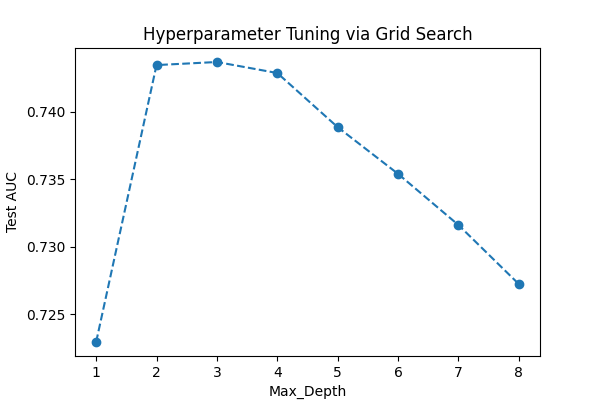

In [7]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 1+result.data.shape[0]), result.cv_results_["mean_test_AUC"], '--o')
plt.xlabel("Max_Depth")
plt.ylabel("Test AUC")
plt.title("Hyperparameter Tuning via Grid Search")
plt.show()

In [ ]:
# Random Search

import scipy
parameter_space = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                   'n_estimators': scipy.stats.randint(100, 2000),
                   'learning_rate': scipy.stats.loguniform(0.001, 0.5)}
result = exp.model_tune(model="XGB-default",
                        method="randomized",
                        parameters=parameter_space,
                        metric=["AUC", "LogLoss"],
                        n_runs=100,
                        test_ratio=0.4,
                        random_state=0)
# result.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

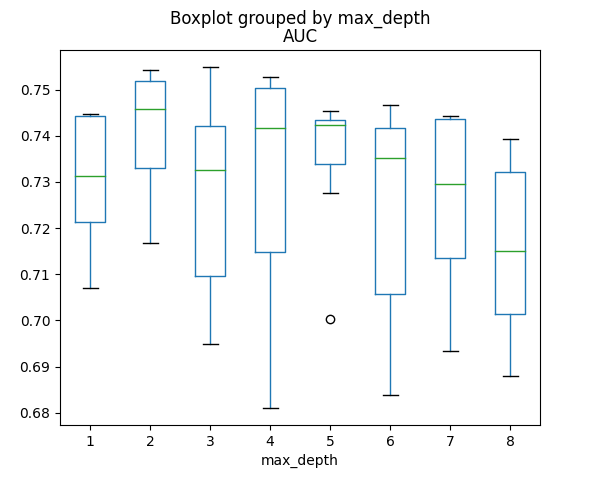

In [9]:
import pandas as pd
df = pd.concat([pd.DataFrame(result.cv_results_['params']),
                pd.DataFrame(result.cv_results_["mean_test_AUC"], columns=["AUC"]),
                pd.DataFrame(result.cv_results_["mean_test_LogLoss"], columns=["LogLoss"])], axis=1)
df.boxplot(column=['AUC'], by='max_depth', grid=False, figsize=(6, 5))
plt.show()

In [10]:
params = result.get_params_ranks(rank=1)
params

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

{'learning_rate': 0.007351262416410614, 'max_depth': 3, 'n_estimators': 1107}

In [11]:
# params = {'learning_rate': 0.007351262416410614, 'max_depth': 3, 'n_estimators': 1107}
exp.model_train(XGBClassifier(**params), name="XGB-HPO")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [12]:
exp.model_diagnose(model="XGB-HPO", show="accuracy_table")

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.7020,0.7703,0.7253,0.5698,0.1939
Test,0.6930,0.7567,0.7191,0.5842,0.1996
Gap,-0.0090,-0.0137,-0.0062,0.0143,0.0056


## 3) Model Explainability

In [13]:
exp.model_explain()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 4) Interpretable Benchmark Models

- Choose XGB2 with n_estimators = 1000, learning_rate = 0.01 and constraints on "Balance" (increasing) and "Utilization" (decreasing)
- Choose GAMI-Net with monotone increasing "Balance", and decreasing "Utilization",
- Run exp.model_interpret() and compare to post-hoc explainability

In [14]:
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [15]:
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 5) Weakness Detection

In [16]:
# Choose XGB-default: WeakSpot, 1D (Delinquency) with ACC/Threshold 1.0; 2D (Deliquency, Utilization) with ACC/Threshold 1.1
exp.model_diagnose()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 6) Benign Overfitting?


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

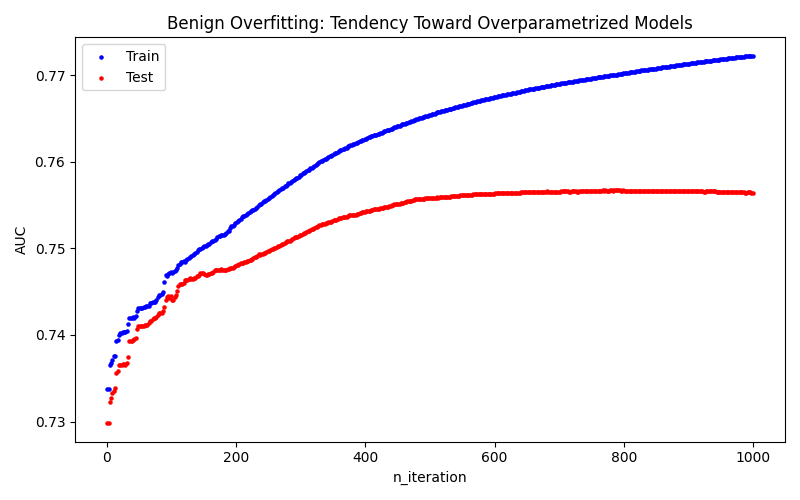

In [17]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)

def score(model, iteration_range):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x, iteration_range=iteration_range)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x, iteration_range=iteration_range)[:, 1])
    tree_idx = np.logical_and(xgbinfo["Tree"] < iteration_range[1], xgbinfo["Tree"] >= iteration_range[0])
    n_leaves = np.sum(xgbinfo[tree_idx].loc[:, ["Feature"]].values == "Leaf")
    return {'n_leaves': n_leaves, 'n_iteration': iteration_range[1], 'train_auc': train_auc, 'test_auc': test_auc}

all_metrics = []
model = exp.get_model("XGB-default").estimator
xgbinfo = model.get_booster().trees_to_dataframe()
for i in range(0, model.get_num_boosting_rounds(), 2):
    metrics = score(model, (0, i + 1))
    all_metrics.append(metrics)
all_resluts = pd.DataFrame(all_metrics)

plt.figure(figsize=(8,5))
plt.scatter(all_resluts["n_iteration"], all_resluts["train_auc"], label="Train", color="blue", s=5)
plt.scatter(all_resluts["n_iteration"], all_resluts["test_auc"], label="Test", color="red",  s=5)
plt.legend()
plt.ylabel("AUC")
plt.xlabel("n_iteration")
plt.title("Benign Overfitting: Tendency Toward Overparametrized Models")
plt.show()

In [18]:
# Choose XGB-default, XGB2, GAMI-Net: Overfit (Delinquency, AUC)
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 7) Robustness

In [19]:
# XGB-default, XGB2 and GAMI-Net: Robustness with Noise Step = 0.05, AUC
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…